# Gold Futures Historical Data Analysis and Prediction

- This notebook provides a step-by-step analysis of gold futures historical data
- and builds a predictive model to forecast future prices.



# Step 1: Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

# Step 2: Load and inspect the data


In [12]:
def load_data(file_path):
    """Load the Gold Futures historical data from CSV file."""
    df = pd.read_csv(file_path, parse_dates=['Date'])
    return df

In [13]:
# Load the data
df = load_data('/content/Gold Futures Historical Data.csv')

# Display the first few rows to inspect the data
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
        Date     Price      Open      High       Low     Vol. Change %
0 2025-04-22  3,408.90  3,445.41  3,509.06  3,383.26  381.45K   -1.06%
1 2025-04-21  3,445.47  3,347.00  3,455.65  3,344.00   14.55K    3.52%
2 2025-04-17  3,328.40  3,357.50  3,371.90  3,296.40  242.07K   -0.54%
3 2025-04-16  3,346.40  3,248.40  3,358.40  3,245.20  258.38K    3.27%
4 2025-04-15  3,240.40  3,226.10  3,250.90  3,225.50  123.47K    0.44%


In [14]:
# Check the data types and missing values
print("\nData information:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe())


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12700 entries, 0 to 12699
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      12700 non-null  datetime64[ns]
 1   Price     12700 non-null  object        
 2   Open      12700 non-null  object        
 3   High      12700 non-null  object        
 4   Low       12700 non-null  object        
 5   Vol.      8153 non-null   object        
 6   Change %  12700 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 694.7+ KB
None

Missing values per column:
Date           0
Price          0
Open           0
High           0
Low            0
Vol.        4547
Change %       0
dtype: int64

Basic statistics:
                                Date
count                          12700
mean   2000-03-27 04:29:58.299212672
min              1975-01-03 00:00:00
25%              1987-08-17 18:00:00
50%              2000-03-29 1

# Step 3: Data Cleaning and Preprocessing (Fixed)


In [15]:
def preprocess_data(df):
    """Clean and preprocess the data for analysis."""
    # Make a copy of the dataframe to avoid modifying the original
    data = df.copy()

    # Ensure the date column is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])

    # Sort the data by date (oldest to newest)
    data = data.sort_values('Date')

    # Convert percentage strings to float values
    data['Change %'] = data['Change %'].str.replace('%', '').astype(float) / 100

    # Handle numeric columns that may have commas as thousand separators
    numeric_columns = ['Price', 'Open', 'High', 'Low']
    for col in numeric_columns:
        if data[col].dtype == object:  # Only process string columns
            data[col] = data[col].str.replace(',', '').astype(float)

    # Handle the volume column (remove 'K' and convert to float)
    data['Vol.'] = data['Vol.'].replace('', np.nan)  # Replace empty strings with NaN
    # For values with 'K', convert to thousands
    data.loc[data['Vol.'].notna(), 'Vol.'] = data.loc[data['Vol.'].notna(), 'Vol.'].str.replace('K', '').astype(float) * 1000

    # Set Date as index
    data.set_index('Date', inplace=True)

    return data


In [16]:
# Preprocess the data
gold_data = preprocess_data(df)

print("\nPreprocessed data:")
print(gold_data.head())


Preprocessed data:
            Price   Open   High    Low Vol.  Change %
Date                                                 
1975-01-03  174.7  173.0  175.5  170.5  NaN   -0.0023
1975-01-06  174.4  172.0  174.5  167.5  NaN   -0.0017
1975-01-07  173.4  171.0  174.0  168.5  NaN   -0.0057
1975-01-08  177.4  176.0  180.0  176.0  NaN    0.0231
1975-01-09  178.3  179.0  179.1  177.0  NaN    0.0051


# Step 4: Exploratory Data Analysis (EDA)


In [17]:
def perform_eda(data):
    """Perform exploratory data analysis on the gold futures data."""
    # Create a figure with multiple subplots
    plt.figure(figsize=(18, 12))

    # Plot 1: Gold Price over time
    plt.subplot(2, 2, 1)
    plt.plot(data.index, data['Price'], color='goldenrod', linewidth=2)
    plt.title('Gold Futures Price Over Time', fontsize=14)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Plot 2: Daily Price Change (%)
    plt.subplot(2, 2, 2)
    plt.plot(data.index, data['Change %'], color='darkblue', linewidth=1)
    plt.title('Daily Price Change (%)', fontsize=14)
    plt.ylabel('Change %', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Plot 3: Distribution of Gold Prices
    plt.subplot(2, 2, 3)
    sns.histplot(data['Price'], kde=True, color='goldenrod')
    plt.title('Distribution of Gold Prices', fontsize=14)
    plt.xlabel('Price (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Plot 4: Box Plot of Monthly Prices
    plt.subplot(2, 2, 4)
    data['Month'] = data.index.month
    sns.boxplot(x='Month', y='Price', data=data, palette='YlOrBr')
    plt.title('Monthly Gold Price Distribution', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional Analysis: Correlation Matrix
    plt.figure(figsize=(10, 8))
    correlation = data[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Gold Futures Data', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

    # Volatility Analysis: Rolling Standard Deviation
    plt.figure(figsize=(14, 6))
    data['Price'].rolling(window=30).std().plot(color='red', linewidth=2)
    plt.title('30-Day Rolling Volatility (Standard Deviation)', fontsize=14)
    plt.ylabel('Standard Deviation', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Time Series Decomposition
    if len(data) > 365:  # Need sufficient data for decomposition
        decomposition = seasonal_decompose(data['Price'], model='additive', period=252)  # 252 trading days in a year
        plt.figure(figsize=(16, 12))
        plt.subplot(411)
        plt.plot(decomposition.observed, color='darkblue')
        plt.title('Observed', fontsize=14)
        plt.subplot(412)
        plt.plot(decomposition.trend, color='darkgreen')
        plt.title('Trend', fontsize=14)
        plt.subplot(413)
        plt.plot(decomposition.seasonal, color='darkorange')
        plt.title('Seasonal', fontsize=14)
        plt.subplot(414)
        plt.plot(decomposition.resid, color='darkred')
        plt.title('Residual', fontsize=14)
        plt.tight_layout()
        plt.show()

    return data

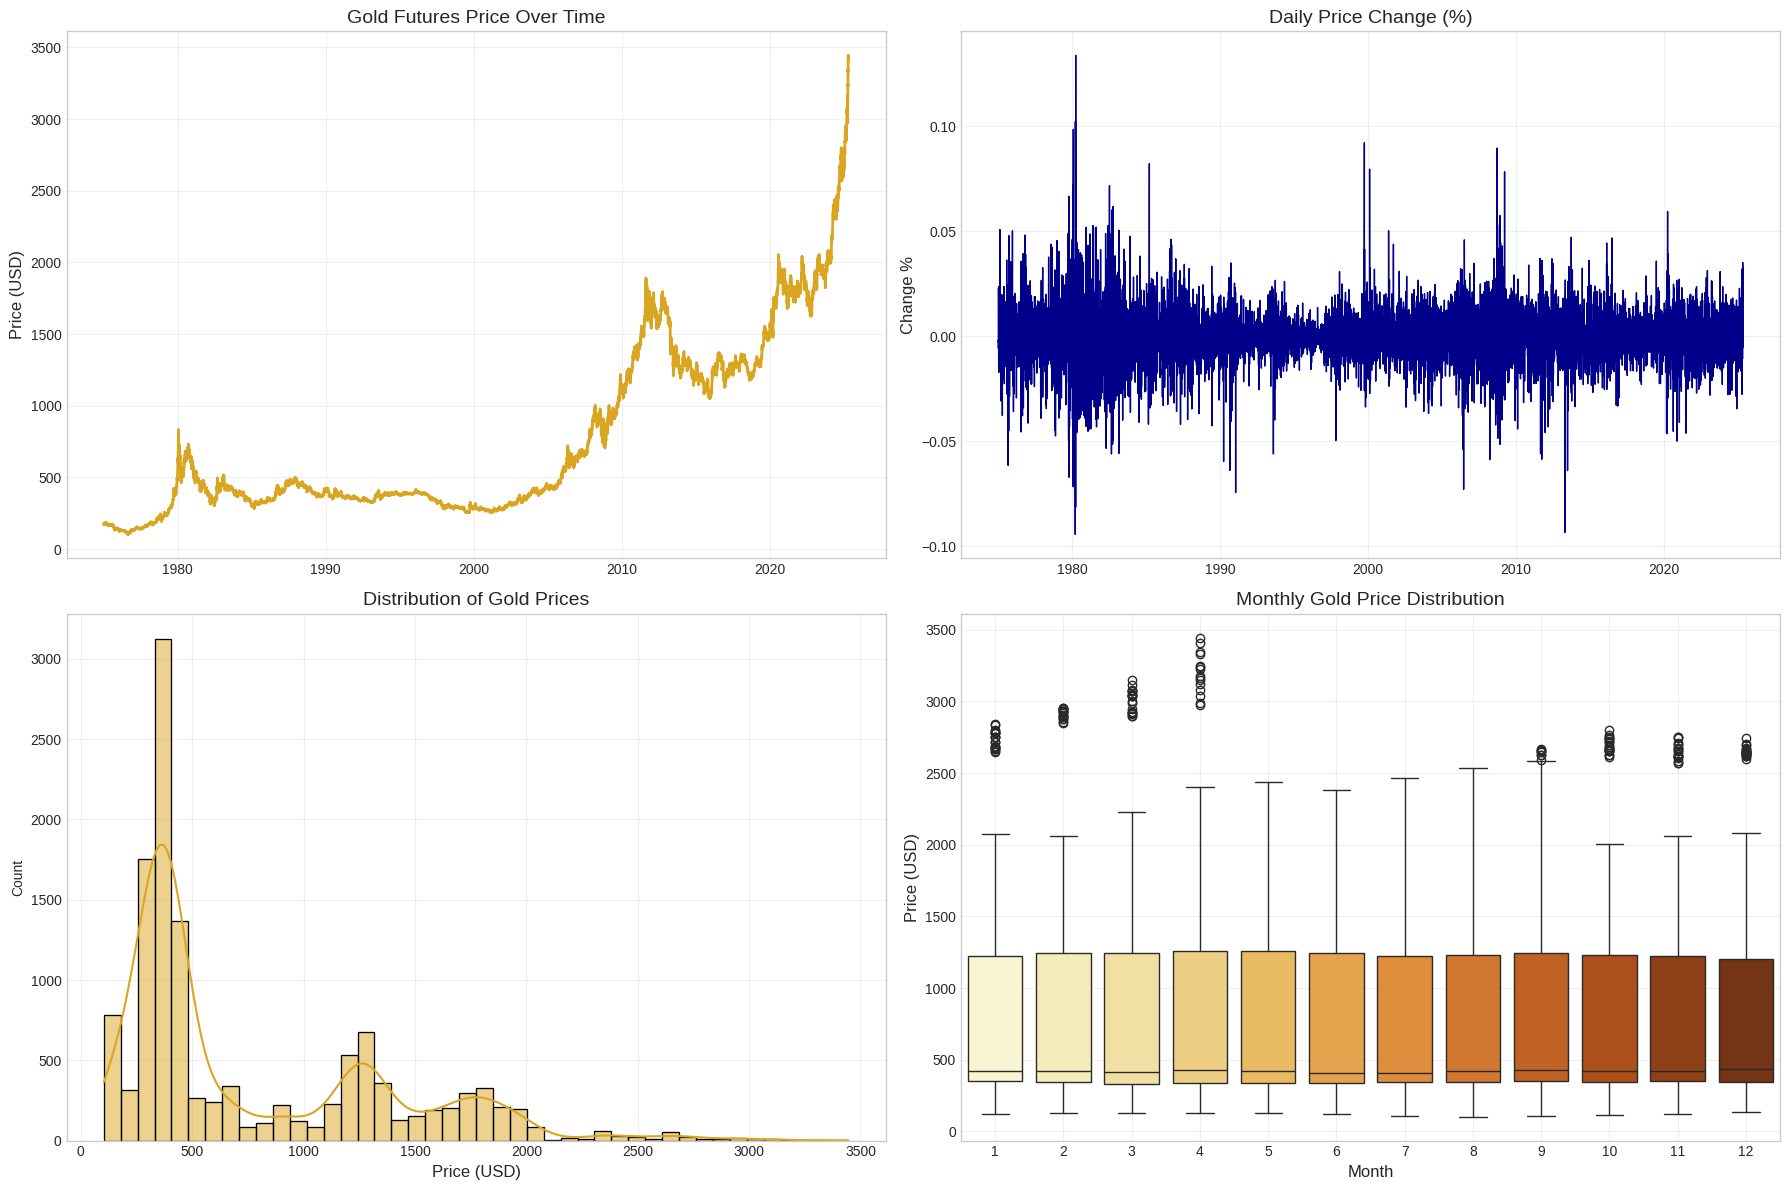

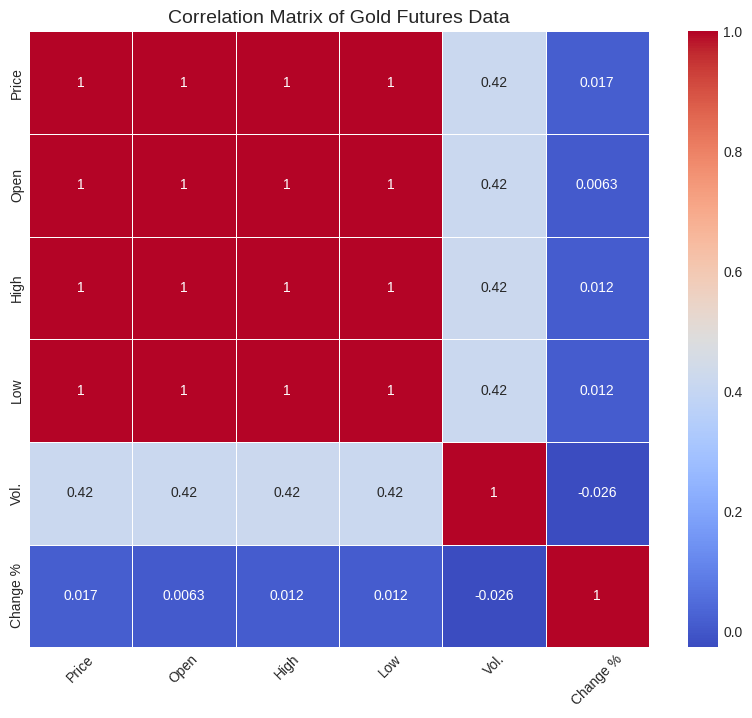

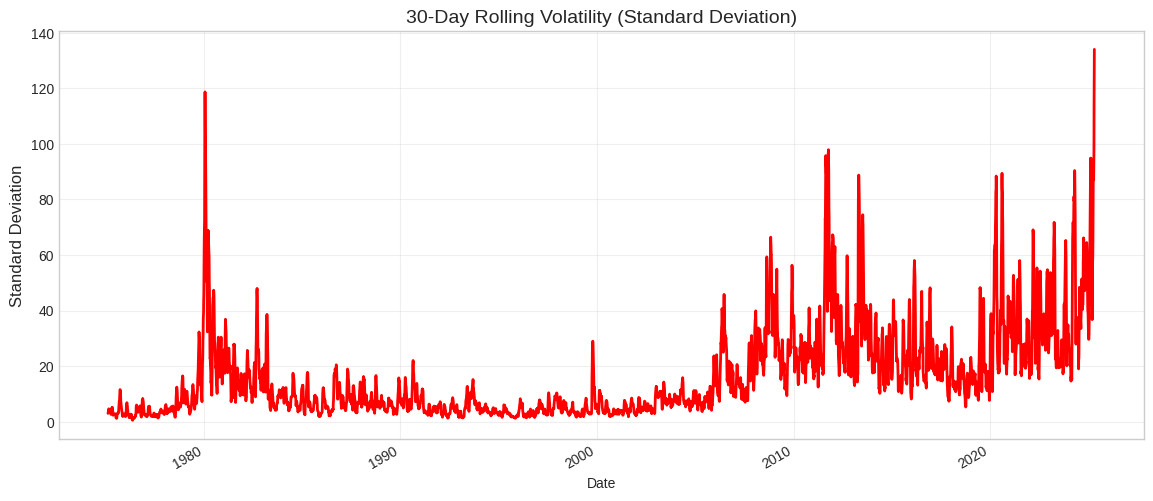

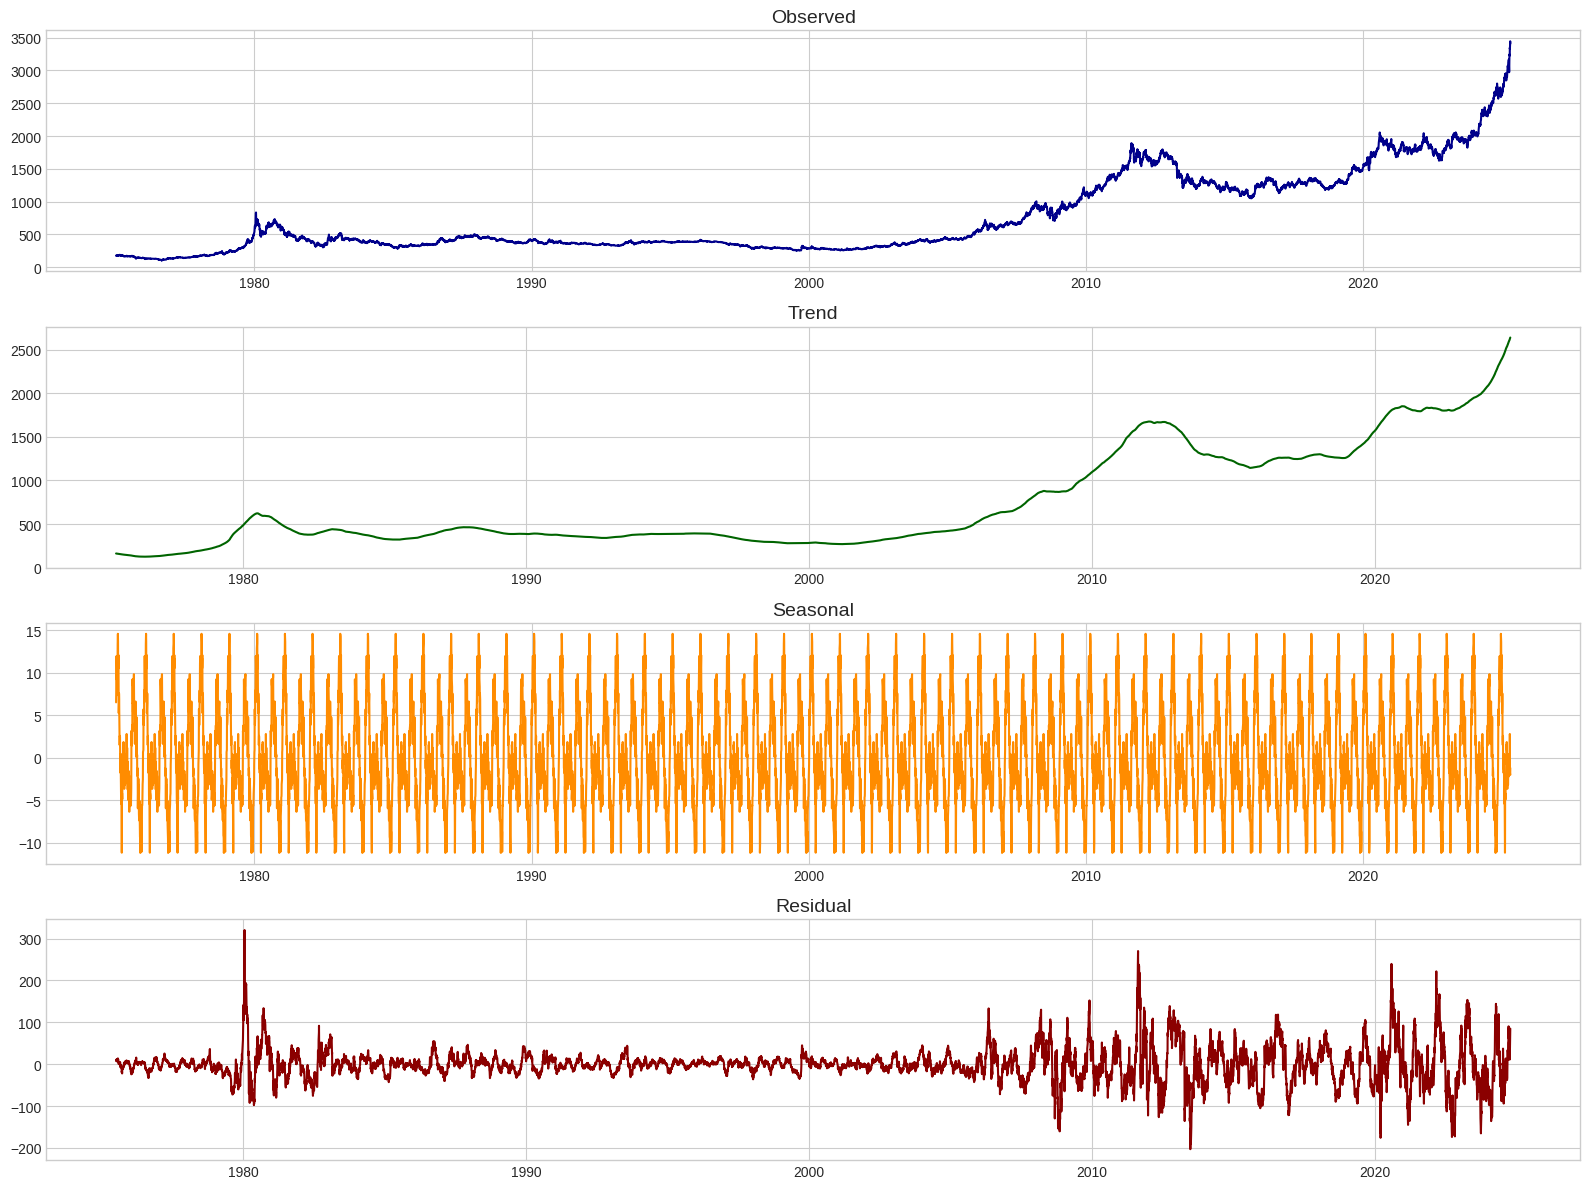

In [18]:
# Perform EDA
gold_data = perform_eda(gold_data)

# Step 5: Feature Engineering


In [19]:
def create_features(data):
    """Create features for predictive modeling."""
    # Make a copy of the data
    df_features = data.copy()

    # Add time-based features
    df_features['Year'] = df_features.index.year
    df_features['Month'] = df_features.index.month
    df_features['Day'] = df_features.index.day
    df_features['DayOfWeek'] = df_features.index.dayofweek
    df_features['Quarter'] = df_features.index.quarter

    # Add technical indicators
    # Moving Averages
    df_features['MA5'] = df_features['Price'].rolling(window=5).mean()
    df_features['MA20'] = df_features['Price'].rolling(window=20).mean()
    df_features['MA50'] = df_features['Price'].rolling(window=50).mean()
    df_features['MA200'] = df_features['Price'].rolling(window=200).mean()

    # Relative Strength Index (RSI)
    delta = df_features['Price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df_features['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df_features['BB_Middle'] = df_features['Price'].rolling(window=20).mean()
    df_features['BB_Std'] = df_features['Price'].rolling(window=20).std()
    df_features['BB_Upper'] = df_features['BB_Middle'] + (df_features['BB_Std'] * 2)
    df_features['BB_Lower'] = df_features['BB_Middle'] - (df_features['BB_Std'] * 2)
    df_features['BB_Width'] = (df_features['BB_Upper'] - df_features['BB_Lower']) / df_features['BB_Middle']

    # Price rate of change
    df_features['Price_ROC_5'] = df_features['Price'].pct_change(periods=5)
    df_features['Price_ROC_10'] = df_features['Price'].pct_change(periods=10)
    df_features['Price_ROC_20'] = df_features['Price'].pct_change(periods=20)

    # Lagged features
    for i in range(1, 6):
        df_features[f'Price_Lag_{i}'] = df_features['Price'].shift(i)
        df_features[f'Return_Lag_{i}'] = df_features['Change %'].shift(i)

    # Drop NaN values resulting from the rolling calculations
    df_features.dropna(inplace=True)

    # Plot some of the engineered features
    plt.figure(figsize=(16, 12))

    # Plot Price with Moving Averages
    plt.subplot(3, 1, 1)
    plt.plot(df_features.index, df_features['Price'], label='Price', color='black')
    plt.plot(df_features.index, df_features['MA5'], label='MA5', color='blue')
    plt.plot(df_features.index, df_features['MA20'], label='MA20', color='orange')
    plt.plot(df_features.index, df_features['MA50'], label='MA50', color='green')
    plt.plot(df_features.index, df_features['MA200'], label='MA200', color='red')
    plt.title('Gold Price with Moving Averages', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot RSI
    plt.subplot(3, 1, 2)
    plt.plot(df_features.index, df_features['RSI'], color='purple')
    plt.axhline(y=70, color='r', linestyle='-', alpha=0.5)
    plt.axhline(y=30, color='g', linestyle='-', alpha=0.5)
    plt.title('Relative Strength Index (RSI)', fontsize=14)
    plt.grid(True, alpha=0.3)

    # Plot Bollinger Bands
    plt.subplot(3, 1, 3)
    plt.plot(df_features.index, df_features['Price'], label='Price', color='black')
    plt.plot(df_features.index, df_features['BB_Middle'], label='Middle Band', color='blue')
    plt.plot(df_features.index, df_features['BB_Upper'], label='Upper Band', color='red')
    plt.plot(df_features.index, df_features['BB_Lower'], label='Lower Band', color='green')
    plt.title('Bollinger Bands', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df_features

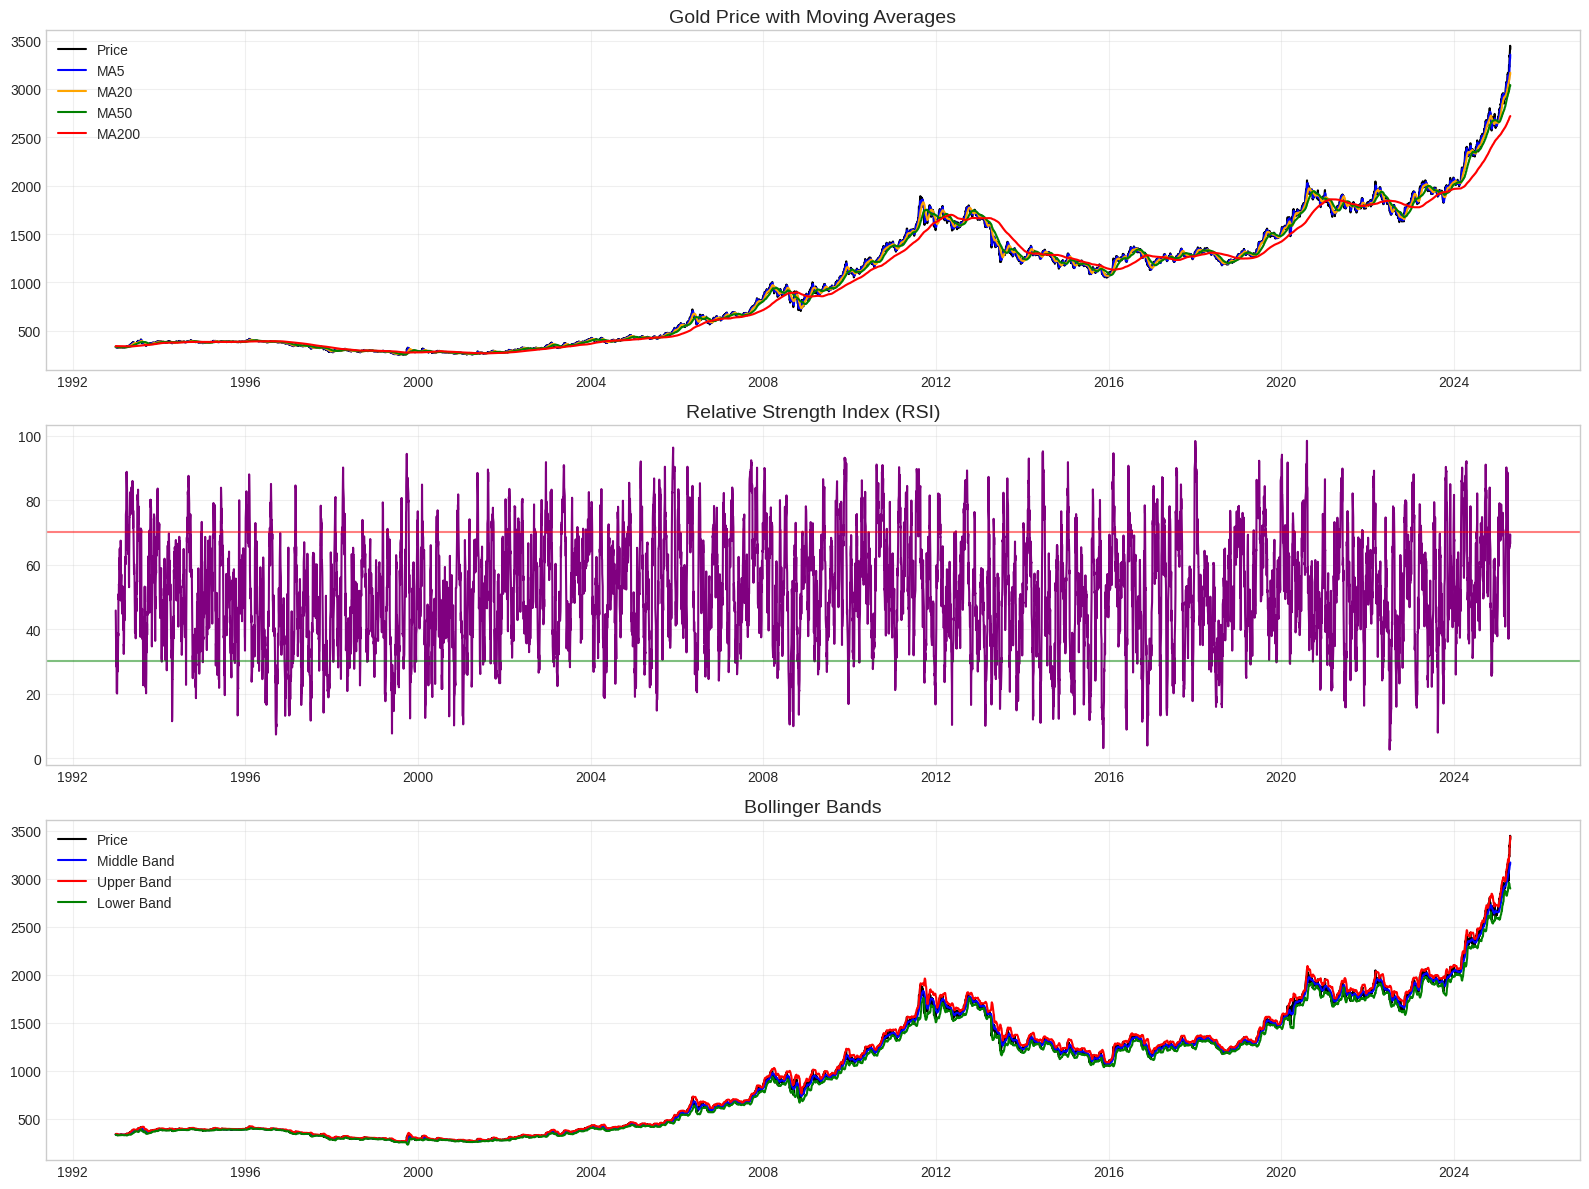


Features created. Dataset shape: (8153, 34)

Feature list:
['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Month', 'Year', 'Day', 'DayOfWeek', 'Quarter', 'MA5', 'MA20', 'MA50', 'MA200', 'RSI', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'BB_Width', 'Price_ROC_5', 'Price_ROC_10', 'Price_ROC_20', 'Price_Lag_1', 'Return_Lag_1', 'Price_Lag_2', 'Return_Lag_2', 'Price_Lag_3', 'Return_Lag_3', 'Price_Lag_4', 'Return_Lag_4', 'Price_Lag_5', 'Return_Lag_5']


In [20]:
# Create features
gold_features = create_features(gold_data)

print("\nFeatures created. Dataset shape:", gold_features.shape)
print("\nFeature list:")
print(gold_features.columns.tolist())

# Step 6: Prepare data for modeling


In [21]:
def prepare_for_modeling(df_features, target_col='Price', forecast_horizon=5):
    """Prepare the data for machine learning modeling."""
    # Create the target variable (future price)
    df_model = df_features.copy()

    # Create target: price after 'forecast_horizon' days
    df_model['Target'] = df_model[target_col].shift(-forecast_horizon)

    # Drop rows with NaN in the target
    df_model.dropna(inplace=True)

    # Define features and target
    features = df_model.drop(['Target', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Month'], axis=1)
    target = df_model['Target']

    # Split the data into training and testing sets (80% train, 20% test)
    # Use time-based split for time series data
    train_size = int(len(features) * 0.8)
    X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
    y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

    # Scale the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\nPrepared data for modeling with {forecast_horizon}-day forecast horizon")
    print(f"Training set: {X_train.shape}")
    print(f"Testing set: {X_test.shape}")

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

# Prepare data for modeling with a 5-day forecast horizon
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler = prepare_for_modeling(gold_features)


Prepared data for modeling with 5-day forecast horizon
Training set: (6518, 28)
Testing set: (1630, 28)


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb  # Import the module as xgb

# Step 7: Build and evaluate models (Fixed)
def build_evaluate_models(X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    """Build and evaluate multiple predictive models."""
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)  # Fixed XGBoost implementation
    }

    results = {}
    predictions = {}

    # Train and evaluate each model
    for name, model in models.items():
        # Use scaled data for Linear Regression, unscaled for tree-based models
        if name == 'Linear Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }

        predictions[name] = y_pred

    # Print metrics table
    print("\nModel Evaluation Metrics:")
    metrics_df = pd.DataFrame(results).T
    print(metrics_df)

    # Plot actual vs predicted for each model
    plt.figure(figsize=(15, 10))

    for i, (name, y_pred) in enumerate(predictions.items(), 1):
        plt.subplot(len(models), 1, i)
        plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
        plt.plot(y_test.index, y_pred, label=f'Predicted ({name})', color='red')
        plt.title(f'{name} - Actual vs Predicted Gold Prices', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # If we have Random Forest model, show feature importance
    if 'Random Forest' in models:
        rf_model = models['Random Forest']

        # Get feature importances
        importances = rf_model.feature_importances_
        feature_names = X_train.columns

        # Sort features by importance
        indices = np.argsort(importances)[::-1]

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importances (Random Forest)', fontsize=16)
        plt.bar(range(X_train.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()

    return models, results, predictions


Model Evaluation Metrics:
                         RMSE         MAE        R²
Linear Regression   44.524243   31.921183  0.987105
Random Forest      410.462391  258.650811 -0.095899
XGBoost            430.370754  277.244001 -0.204784


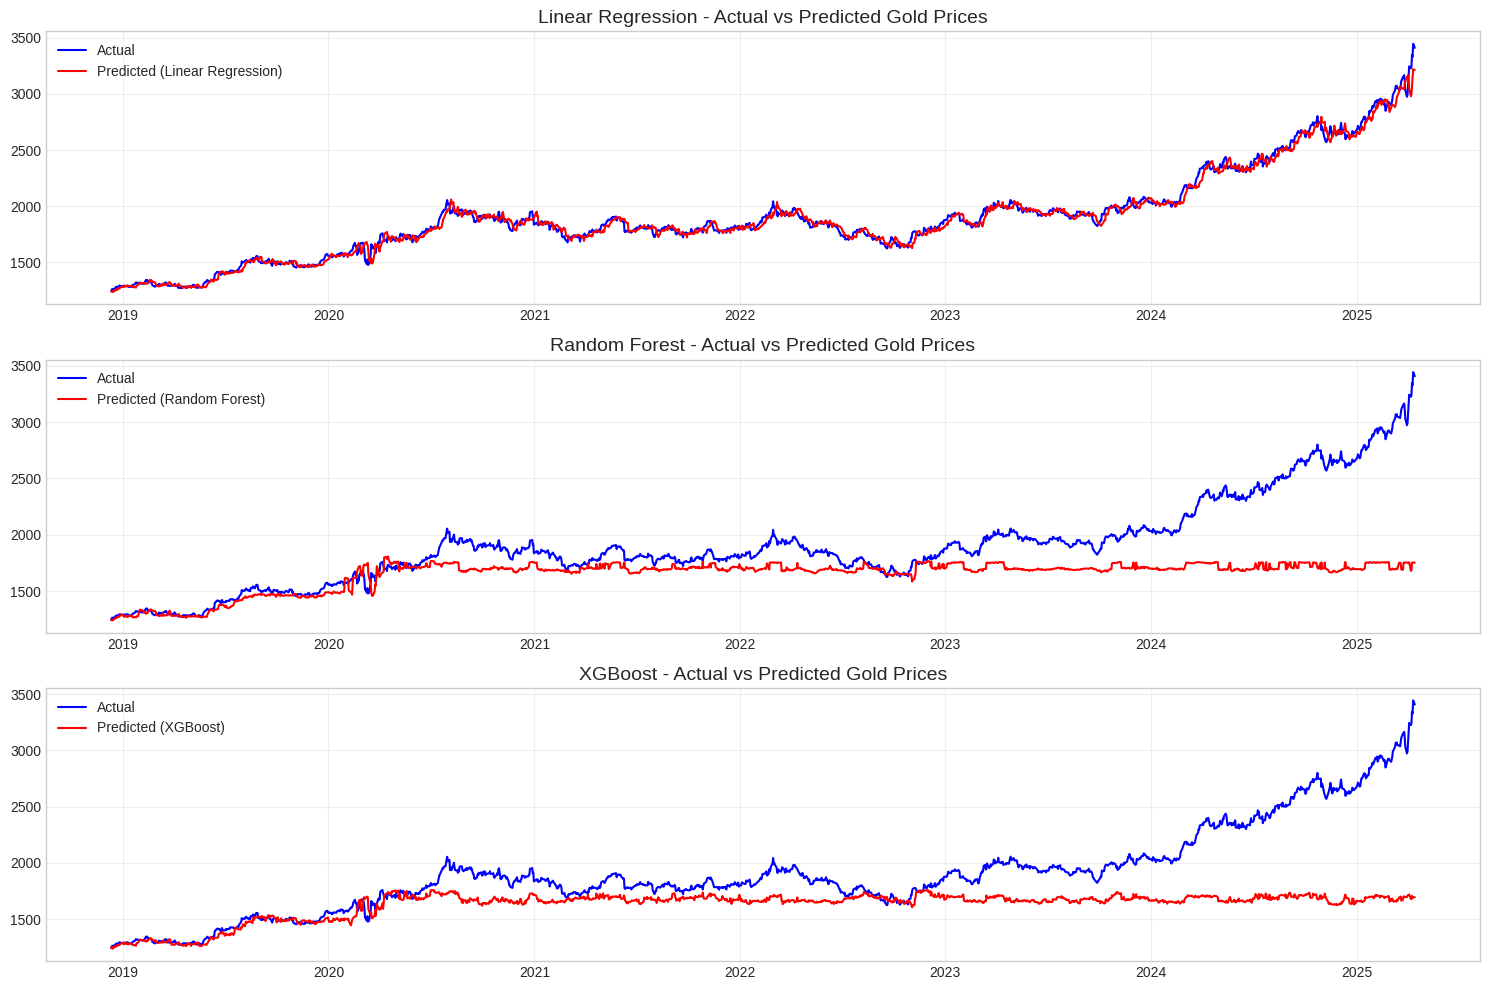

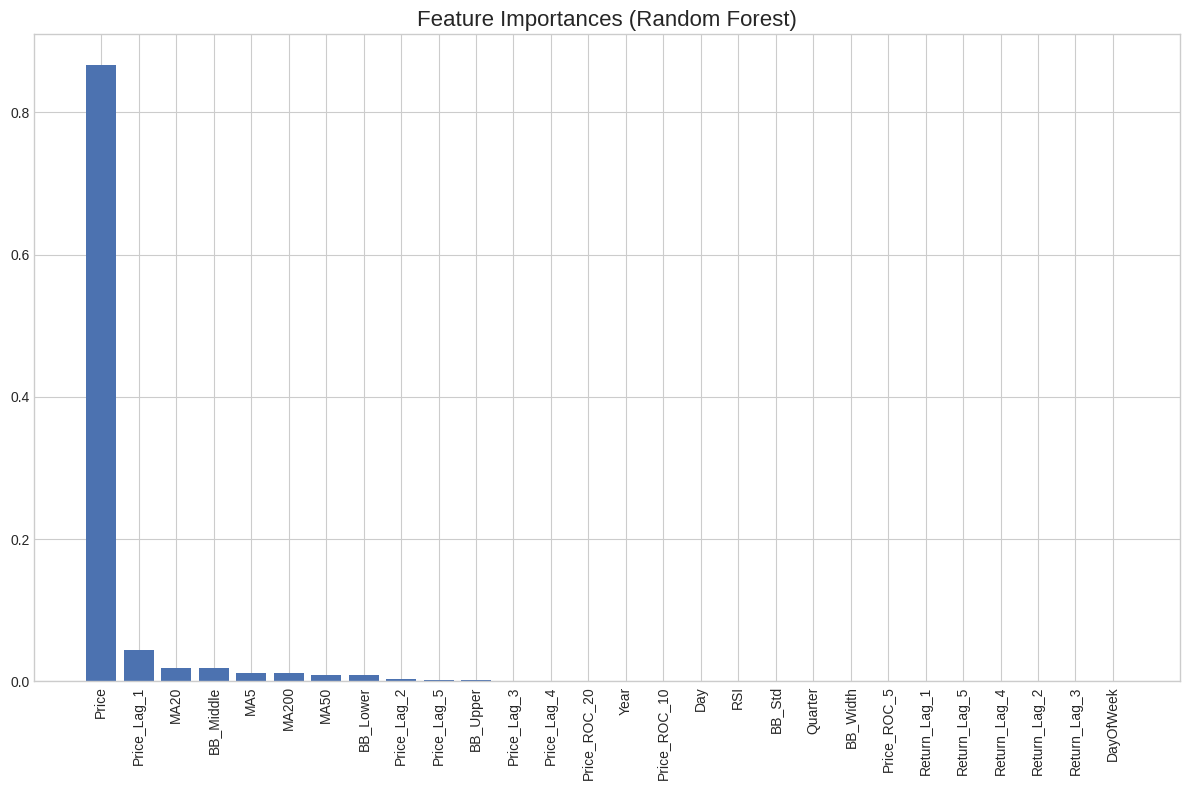

In [27]:
# Use the corrected function
models, results, predictions = build_evaluate_models(X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

# Step 8: Time Series Forecasting with ARIMA


In [28]:
def build_arima_model(data, p=5, d=1, q=0):
    """Build an ARIMA model for time series forecasting."""
    # Use only the Price column for ARIMA
    ts_data = data['Price'].copy()

    # Split the data
    train_size = int(len(ts_data) * 0.8)
    train_data = ts_data[:train_size]
    test_data = ts_data[train_size:]

    # Plot ACF and PACF to help identify p and q parameters
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(train_data.diff().dropna(), lags=40, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)', fontsize=14)

    plt.subplot(122)
    plot_pacf(train_data.diff().dropna(), lags=40, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)', fontsize=14)

    plt.tight_layout()
    plt.show()

    # Fit ARIMA model
    print("\nFitting ARIMA model...")
    model = ARIMA(train_data, order=(p, d, q))
    model_fit = model.fit()

    # Summary of the model
    print("\nARIMA Model Summary:")
    print(model_fit.summary())

    # Make predictions
    forecast_steps = len(test_data)
    forecast = model_fit.forecast(steps=forecast_steps)

    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
    plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
    plt.title(f'ARIMA({p},{d},{q}) Forecast', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate metrics
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data, forecast)

    print(f"\nARIMA Model Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    return model_fit, forecast

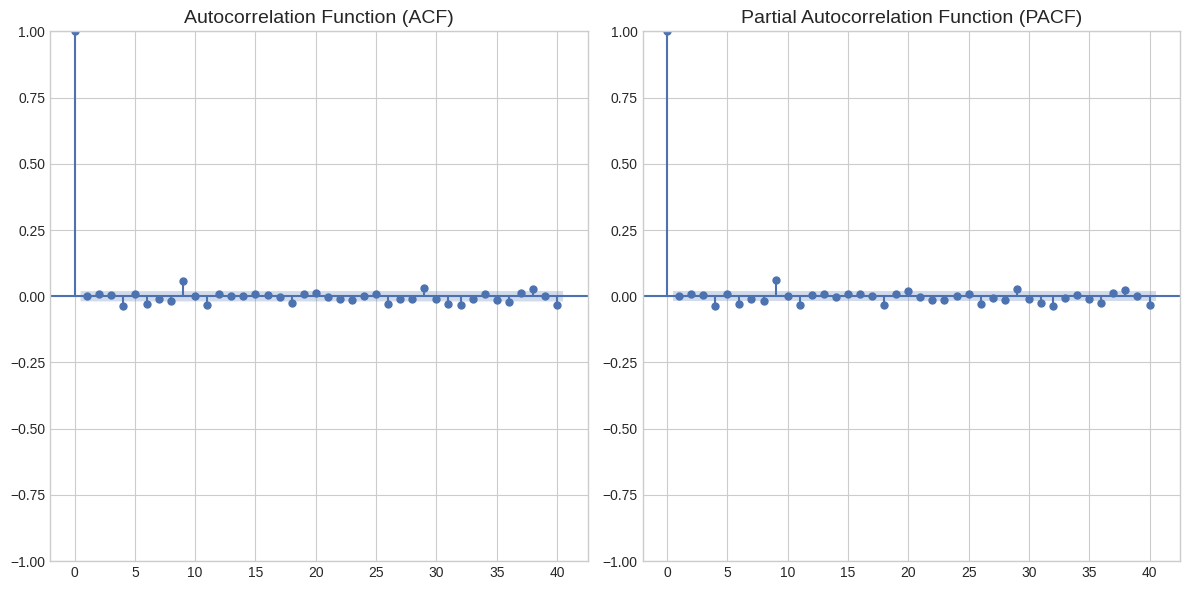


Fitting ARIMA model...

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                10160
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -36096.249
Date:                Wed, 23 Apr 2025   AIC                          72204.498
Time:                        17:49:58   BIC                          72247.855
Sample:                             0   HQIC                         72219.163
                              - 10160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0028      0.004      0.665      0.506      -0.005       0.011
ar.L2          0.0081      0.004      1.853      0.064      -0.000       0.017
ar.L3 

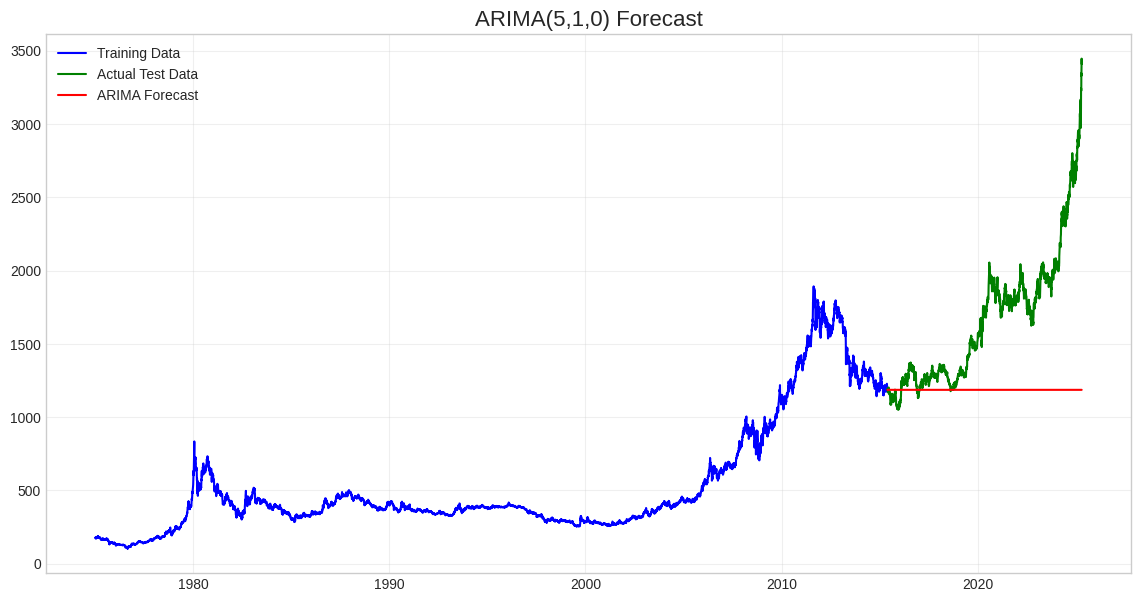


ARIMA Model Metrics:
RMSE: 654.37
MAE: 485.95


In [29]:
# Build ARIMA model
arima_model, arima_forecast = build_arima_model(gold_data)

# Step 9: Future Price Prediction


In [65]:
def predict_future_prices(model, features, scaler, last_data, days=30):
    """Generate predictions for future gold prices."""
    # Find the best model based on RMSE
    best_model_name = min(results, key=lambda k: results[k]['RMSE'])
    best_model = models[best_model_name]

    print(f"\nUsing {best_model_name} for future predictions.")

    # Create a dataframe for future dates
    last_date = features.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)

    # Initialize prediction dataframe

    predictions = pd.DataFrame(index=future_dates, columns=['Predicted_Price'])
    predictions['Predicted_Price'] = predictions['Predicted_Price'].astype(float)


    # Get the last known data point as a NumPy array with numeric values only
    current_data = last_data.copy().values.astype(float)

    # Make predictions for each future day
    for i in range(days):
        if best_model_name in ['Random Forest', 'XGBoost']:
            predicted_price = best_model.predict([current_data])[0]
        else:
            scaled_data = scaler.transform([current_data])
            predicted_price = best_model.predict(scaled_data)[0]

        predictions.iloc[i] = predicted_price

        # Update lagged features
        for j in range(5, 0, -1):  # Iterate from 5 to 1
            current_feature = f'Price_Lag_{j}'
            next_feature = f'Price_Lag_{j - 1}'

            if current_feature in features.columns and next_feature in features.columns:
                current_feature_index = features.columns.get_loc(current_feature)
                next_feature_index = features.columns.get_loc(next_feature)
                current_data[current_feature_index] = current_data[next_feature_index]

        # Update Price_Lag_1 and Price with the predicted price
        current_data[features.columns.get_loc('Price_Lag_1')] = predicted_price
        current_data[features.columns.get_loc('Price')] = predicted_price

    # Plot the predictions
    plt.figure(figsize=(14, 7))

    # Plot historical data
    historical_end = min(30, len(features))  # Last 30 days of historical data
    plt.plot(features.index[-historical_end:], features['Price'][-historical_end:],
             label='Historical Prices', color='blue')

    # Plot predictions
    plt.plot(predictions.index, predictions['Predicted_Price'],
             label='Predicted Prices', color='red', linestyle='--')

    # Add confidence interval (simplified)
    rmse = results[best_model_name]['RMSE']
    plt.fill_between(predictions.index,
                    predictions['Predicted_Price'] - rmse * 1.96,
                    predictions['Predicted_Price'] + rmse * 1.96,
                    color='red', alpha=0.2)

    plt.title('Gold Futures Price Prediction', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return predictions


Using Linear Regression for future predictions.


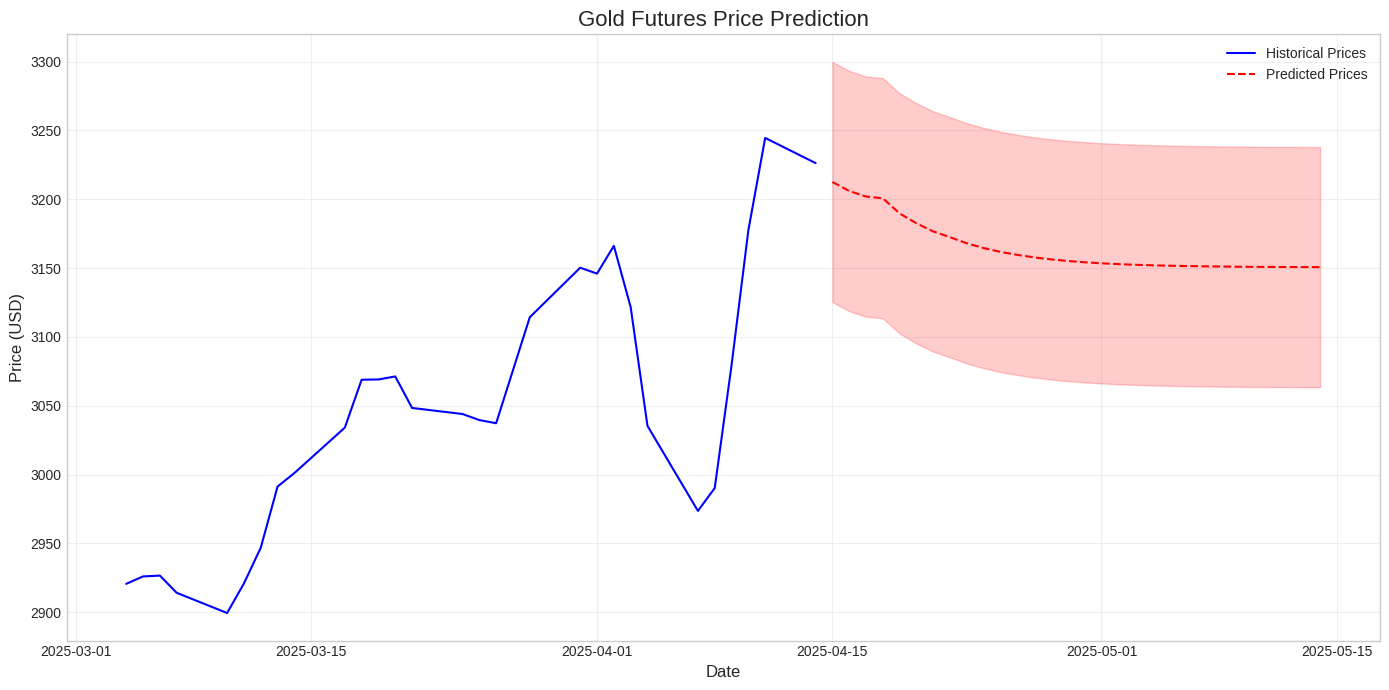


Future price predictions for the next 30 days:
            Predicted_Price
2025-04-15      3212.576094
2025-04-16      3206.046995
2025-04-17      3201.993368
2025-04-18      3200.745744
2025-04-19      3189.694179
2025-04-20      3182.541512
2025-04-21      3176.619686
2025-04-22      3172.461927
2025-04-23      3167.984123
2025-04-24      3164.567012


In [66]:
# Get last available data point for prediction
last_data_point = X_test.iloc[-1]

# Predict future prices for the next 30 days
future_predictions = predict_future_prices(models, X_test, scaler, last_data_point, days=30)

print("\nFuture price predictions for the next 30 days:")
print(future_predictions.head(10))

# Step 10: Trading Strategy Simulation


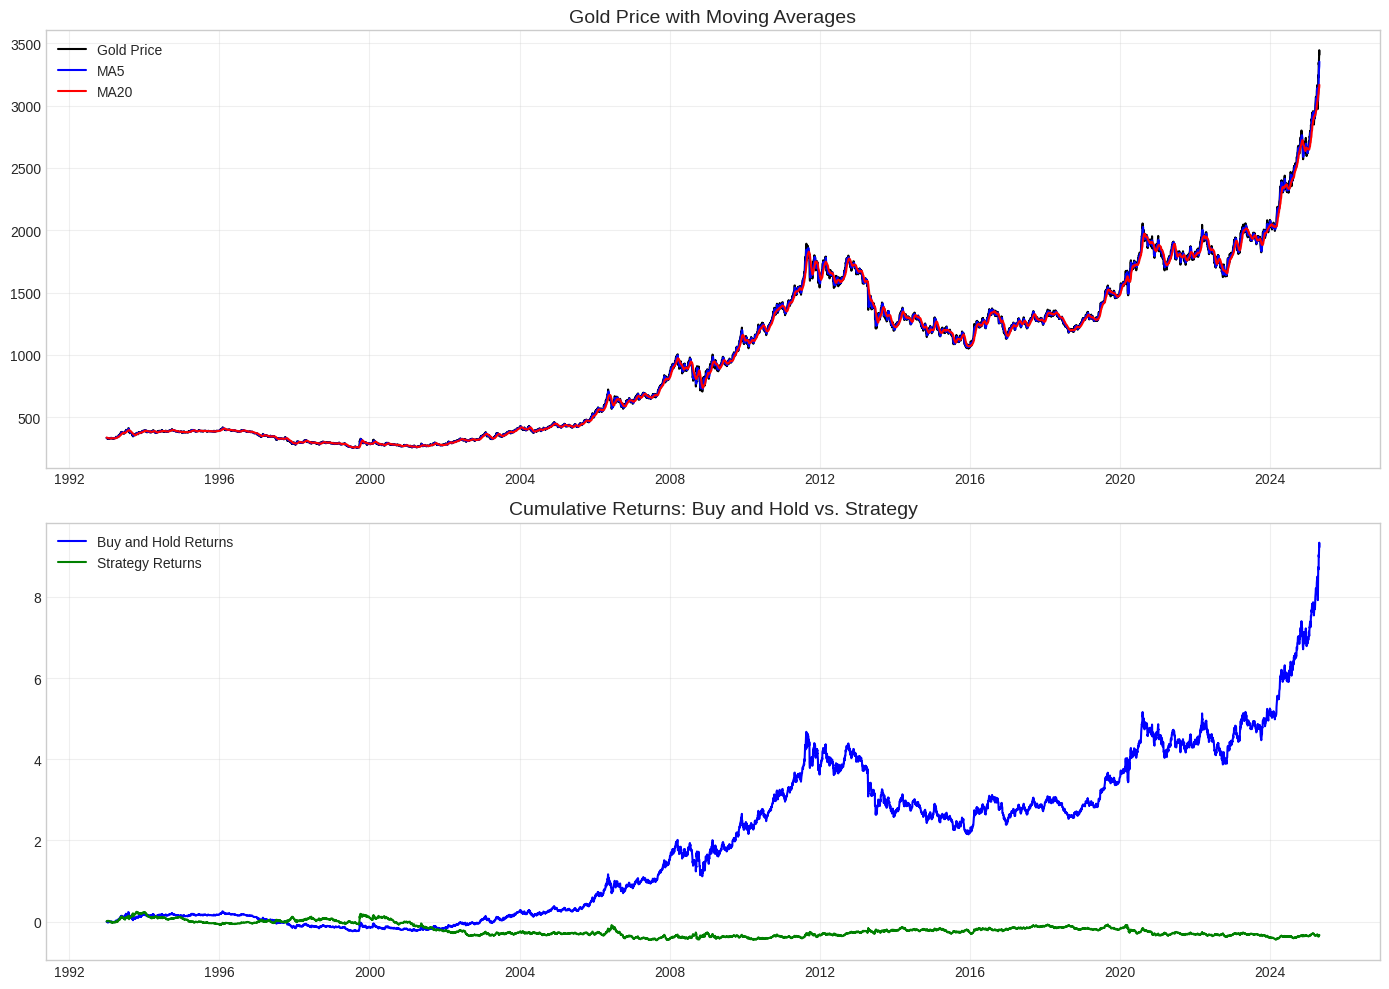


Trading Strategy Performance Metrics:
Total Return - Buy and Hold: 922.77%, Strategy: -33.58%
Annualized Return - Buy and Hold: 5.09%, Strategy: -0.87%
Maximum Drawdown - Buy and Hold: -1700.00%, Strategy: -290.32%
Sharpe Ratio - Buy and Hold: 0.52, Strategy: 0.00


In [67]:
def simulate_trading_strategy(data, strategy='ma_crossover'):
    """Simulate a simple trading strategy and calculate returns."""
    df_strategy = data.copy()

    if strategy == 'ma_crossover':
        # Moving Average Crossover Strategy
        # Buy when short-term MA crosses above long-term MA
        # Sell when short-term MA crosses below long-term MA
        df_strategy['Signal'] = 0
        df_strategy['Signal'][df_strategy['MA5'] > df_strategy['MA20']] = 1  # Buy signal
        df_strategy['Signal'][df_strategy['MA5'] < df_strategy['MA20']] = -1  # Sell signal

        # Calculate daily returns
        df_strategy['Market_Returns'] = df_strategy['Price'].pct_change()

        # Calculate strategy returns (position * market returns)
        df_strategy['Strategy_Returns'] = df_strategy['Signal'].shift(1) * df_strategy['Market_Returns']

        # Calculate cumulative returns
        df_strategy['Cumulative_Market_Returns'] = (1 + df_strategy['Market_Returns']).cumprod() - 1
        df_strategy['Cumulative_Strategy_Returns'] = (1 + df_strategy['Strategy_Returns']).cumprod() - 1

        # Plot the results
        plt.figure(figsize=(14, 10))

        # Plot 1: Price with MA5 and MA20
        plt.subplot(2, 1, 1)
        plt.plot(df_strategy.index, df_strategy['Price'], label='Gold Price', color='black')
        plt.plot(df_strategy.index, df_strategy['MA5'], label='MA5', color='blue')
        plt.plot(df_strategy.index, df_strategy['MA20'], label='MA20', color='red')
        plt.title('Gold Price with Moving Averages', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: Cumulative Returns
        plt.subplot(2, 1, 2)
        plt.plot(df_strategy.index, df_strategy['Cumulative_Market_Returns'],
                 label='Buy and Hold Returns', color='blue')
        plt.plot(df_strategy.index, df_strategy['Cumulative_Strategy_Returns'],
                 label='Strategy Returns', color='green')
        plt.title('Cumulative Returns: Buy and Hold vs. Strategy', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Calculate performance metrics
        # Annualized return
        days = (df_strategy.index[-1] - df_strategy.index[0]).days
        ann_factor = 252 / days  # Trading days in a year

        market_return = df_strategy['Cumulative_Market_Returns'].iloc[-1]
        strategy_return = df_strategy['Cumulative_Strategy_Returns'].iloc[-1]

        ann_market_return = (1 + market_return) ** ann_factor - 1
        ann_strategy_return = (1 + strategy_return) ** ann_factor - 1

        # Max drawdown
        market_cummax = df_strategy['Cumulative_Market_Returns'].cummax()
        strategy_cummax = df_strategy['Cumulative_Strategy_Returns'].cummax()

        market_drawdown = (df_strategy['Cumulative_Market_Returns'] - market_cummax) / market_cummax
        strategy_drawdown = (df_strategy['Cumulative_Strategy_Returns'] - strategy_cummax) / strategy_cummax

        market_max_drawdown = market_drawdown.min()
        strategy_max_drawdown = strategy_drawdown.min()

        # Sharpe ratio (assuming risk-free rate of 0)
        market_sharpe = (df_strategy['Market_Returns'].mean() / df_strategy['Market_Returns'].std()) * np.sqrt(252)
        strategy_sharpe = (df_strategy['Strategy_Returns'].mean() / df_strategy['Strategy_Returns'].std()) * np.sqrt(252)

        print("\nTrading Strategy Performance Metrics:")
        print(f"Total Return - Buy and Hold: {market_return:.2%}, Strategy: {strategy_return:.2%}")
        print(f"Annualized Return - Buy and Hold: {ann_market_return:.2%}, Strategy: {ann_strategy_return:.2%}")
        print(f"Maximum Drawdown - Buy and Hold: {market_max_drawdown:.2%}, Strategy: {strategy_max_drawdown:.2%}")
        print(f"Sharpe Ratio - Buy and Hold: {market_sharpe:.2f}, Strategy: {strategy_sharpe:.2f}")

    return df_strategy

# Simulate trading strategy
strategy_results = simulate_trading_strategy(gold_features)

# Step 11: Conclusion and Recommendations


In [68]:
def generate_conclusion(data, predictions, best_model_name):
    """Generate conclusions and recommendations based on the analysis."""
    # Current price trend (last 30 days)
    recent_data = data.iloc[-30:]
    current_price = data['Price'].iloc[-1]
    price_30d_ago = data['Price'].iloc[-30]
    price_change_30d = (current_price - price_30d_ago) / price_30d_ago

    # Predicted price trend (next 30 days)
    future_price = predictions['Predicted_Price'].iloc[-1]
    predicted_change = (future_price - current_price) / current_price

    # Technical indicators
    rsi = data['RSI'].iloc[-1]
    ma5 = data['MA5'].iloc[-1]
    ma20 = data['MA20'].iloc[-1]
    ma_signal = "bullish" if ma5 > ma20 else "bearish"

    print("\n=== Gold Futures Analysis Conclusion ===")
    print(f"\nCurrent Gold Price: ${current_price:.2f}")
    print(f"30-Day Price Change: {price_change_30d:.2%}")
    print(f"RSI: {rsi:.2f} ({'Overbought' if rsi > 70 else 'Oversold' if rsi < 30 else 'Neutral'})")
    print(f"Moving Average Signal: {ma_signal.capitalize()}")

    print("\nModel Prediction Summary:")
    print(f"Best Performing Model: {best_model_name}")
    print(f"Predicted Price in 30 Days: ${future_price:.2f}")
    print(f"Predicted 30-Day Change: {predicted_change:.2%}")

    print("\nRecommendations:")

    # Generate recommendations based on technical indicators and predictions
    if predicted_change > 0.05:
        print("- Strong BUY recommendation based on model predictions showing significant upside potential.")
    elif predicted_change > 0.02:
        print("- Moderate BUY recommendation with positive price momentum expected.")
    elif predicted_change < -0.05:
        print("- Strong SELL recommendation as model predicts significant price drop.")
    elif predicted_change < -0.02:
        print("- Moderate SELL recommendation with negative price momentum expected.")
    else:
        print("- HOLD recommendation as model predicts relatively stable prices.")

    # Additional recommendations based on technical indicators
    if rsi > 70:
        print("- Warning: Gold may be overbought according to RSI indicator.")
    elif rsi < 30:
        print("- Note: Gold may be oversold according to RSI indicator.")

    if ma_signal == "bullish":
        print("- Technical indicators show bullish momentum with short-term MA above long-term MA.")
    else:
        print("- Technical indicators show bearish momentum with short-term MA below long-term MA.")

    print("\nRisk Assessment:")
    print("- Gold prices historically serve as a hedge against inflation and economic uncertainty.")
    print("- Monitor key economic indicators such as inflation rates, central bank policies, and USD strength.")
    print("- Consider diversification strategies to manage portfolio risk.")

    print("\nDisclaimer: This analysis is for informational purposes only and should not be considered financial advice.")

# Get the best model name for the conclusion
best_model_name = min(results, key=lambda k: results[k]['RMSE'])

# Generate conclusion and recommendations
generate_conclusion(gold_features, future_predictions, best_model_name)


=== Gold Futures Analysis Conclusion ===

Current Gold Price: $3408.90
30-Day Price Change: 16.71%
RSI: 66.56 (Neutral)
Moving Average Signal: Bullish

Model Prediction Summary:
Best Performing Model: Linear Regression
Predicted Price in 30 Days: $3150.71
Predicted 30-Day Change: -7.57%

Recommendations:
- Strong SELL recommendation as model predicts significant price drop.
- Technical indicators show bullish momentum with short-term MA above long-term MA.

Risk Assessment:
- Gold prices historically serve as a hedge against inflation and economic uncertainty.
- Monitor key economic indicators such as inflation rates, central bank policies, and USD strength.
- Consider diversification strategies to manage portfolio risk.

Disclaimer: This analysis is for informational purposes only and should not be considered financial advice.


# Step 12: Save the model and results


In [69]:
def save_model_and_results(models, best_model_name, features, predictions):
    """Save the best model and results for future use."""
    import pickle
    import os

    # Create directory if it doesn't exist
    if not os.path.exists('model_output'):
        os.makedirs('model_output')

    # Save the best model
    best_model = models[best_model_name]
    with open(f'model_output/gold_price_prediction_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    # Save feature list
    feature_list = features.columns.tolist()
    with open(f'model_output/feature_list.pkl', 'wb') as f:
        pickle.dump(feature_list, f)

    # Save scaler
    with open(f'model_output/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

    # Save predictions to CSV
    predictions.to_csv('model_output/future_predictions.csv')

    # Save a summary of results
    with open('model_output/model_summary.txt', 'w') as f:
        f.write("Gold Futures Price Prediction - Model Summary\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Best Model: {best_model_name}\n\n")

        f.write("Model Evaluation Metrics:\n")
        for model_name, metrics in results.items():
            f.write(f"{model_name}:\n")
            for metric_name, value in metrics.items():
                f.write(f"  {metric_name}: {value:.4f}\n")
            f.write("\n")

        f.write("\nFeature Importance (if Random Forest was used):\n")
        if best_model_name == 'Random Forest':
            importances = best_model.feature_importances_
            feature_importance = [(feature, imp) for feature, imp in zip(feature_list, importances)]
            feature_importance.sort(key=lambda x: x[1], reverse=True)

            for feature, importance in feature_importance:
                f.write(f"{feature}: {importance:.4f}\n")

    print("\nModel and results saved to 'model_output' directory.")
    print("Files saved:")
    print("- gold_price_prediction_model.pkl (Best model)")
    print("- feature_list.pkl (Features used for prediction)")
    print("- scaler.pkl (Feature scaler)")
    print("- future_predictions.csv (Predicted prices)")
    print("- model_summary.txt (Summary of results)")

# Save model and results
save_model_and_results(models, best_model_name, gold_features, future_predictions)



Model and results saved to 'model_output' directory.
Files saved:
- gold_price_prediction_model.pkl (Best model)
- feature_list.pkl (Features used for prediction)
- scaler.pkl (Feature scaler)
- future_predictions.csv (Predicted prices)
- model_summary.txt (Summary of results)


# Step 13: Function for reusing the model for new predictions


In [70]:
def load_and_predict(new_data, days_to_predict=30):
    """Load the saved model and make predictions on new data."""
    import pickle

    # Load the model, features, and scaler
    with open('model_output/gold_price_prediction_model.pkl', 'rb') as f:
        model = pickle.load(f)

    with open('model_output/feature_list.pkl', 'rb') as f:
        feature_list = pickle.load(f)

    with open('model_output/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    # Process the new data to create features
    # This would require implementing the same feature engineering steps
    # from the create_features function

    # Make predictions
    # Similar to the predict_future_prices function

    print("Model loaded and ready for new predictions.")
    print("To use this function, you need to implement data preprocessing steps for your new data.")

print("\n=== Gold Futures Analysis and Prediction Notebook Complete ===")
print("You can now use this model to predict future gold prices based on historical data.")
print("For new predictions, use the load_and_predict function with your updated data.")


=== Gold Futures Analysis and Prediction Notebook Complete ===
You can now use this model to predict future gold prices based on historical data.
For new predictions, use the load_and_predict function with your updated data.
